# Indoor Semantic Image Segmentation

**Notebook created in PyTorch by [ Xavier Riera, Albert Mestre, José Javier Gómez] for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgraduate-course-artificial-intelligence-deep-learning/) (2020).**



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import pandas as pd
from skimage import io
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from google.colab import drive
drive.mount('/content/drive/')

class IndoorDataset(Dataset):

  def __init__(self, csv_file, root_dir, transform = None, transform_img = None):
    self.dataset = pd.read_csv(root_dir + csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.transform_img = transform_img

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self,index):
    RGBImage = io.imread(self.root_dir + self.dataset.iloc[index, 0])                             
    labelsImage = io.imread(self.root_dir + self.dataset.iloc[index, 1])                      

    if self.transform is not None:
      RGBImage, labelsImage = self.transform( (RGBImage, labelsImage) )

    if self.transform_img is not None:
      RGBImage, labelsImage = self.transform_img(RGBImage)
    return RGBImage , labelsImage

class ResizeAndRandomCrop(object):
    def __init__(self, size=300):
        self.size = size

    def random_crop(self, image, labels, size=256):
      i, j, h, w = transforms.RandomCrop.get_params(image, [size, size])
      image = transforms.functional.crop(image, i, j, h, w)
      labels = transforms.functional.crop(labels, i, j, h, w)
      return image, labels

    def __call__(self, sample):

        image,target = sample
        image = Image.fromarray(image)
        target = Image.fromarray(target)
        image = transforms.functional.resize(image, self.size)
        target = transforms.functional.resize(target, self.size, interpolation=Image.NEAREST)

        #Comment the following line to get 300x300 images and not 256x256
        #image, target = self.random_crop(image,target)
        
        return (image, target)

class ToTensor(object):

    def __call__(self, sample):

        image, target = sample
        image = transforms.functional.to_tensor(np.array(image))
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return (image, target)

directory = 'drive/My Drive/Compartida con Albert/'
PATH_IMG = directory + 'Images/'


fparams = {
    
    #Directory definition
    'imagePath': PATH_IMG,

    #CSV
    'CSVTrain': 'train.csv',
}

hparams = {

    #BATCH_SIZE 
    'batch_size': 1,

}

transform_train = transforms.Compose([
        ResizeAndRandomCrop(300),
        ToTensor(),
    ])



Mounted at /content/drive/


In [ ]:
train_data = IndoorDataset(fparams['CSVTrain'], fparams['imagePath'], transform = transform_train)
train_loader = DataLoader(dataset=train_data, batch_size=hparams['batch_size'], shuffle=False, num_workers=2) #Pongo el shuffle a False porque me da igual el orden

LabelVectorTrain = []

for batch_idx, (data, target) in enumerate(train_loader):
  numpyTarget = np.asarray(target[0])
  LabelVectorTrain.append(numpyTarget)

ArrayLabelTrain = np.asarray(LabelVectorTrain)

plt.figure(figsize=(18,6))
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
plt.hist([ArrayLabelTrain.ravel() ] ,label=['Train'] , bins=bins, density = False)
plt.legend()
labels = ['Bed','Book','Ceil','Chair','Floor','Furn','Objs','Paint','Sofa','Table','TV','Wall','Wind']
positions = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5]
plt.title('Histogram of 13 label Dataset')
plt.xticks(ticks = positions, labels= labels)
plt.show()


Filas = ArrayLabelTrain.ravel()
Number = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in Filas:
  if i != 255:
    Number[i] = Number[i] + 1
    
print(Number)


[0.57320767 3.71092397 1.41089921 0.56782134 0.1951699  0.13435666
 0.15355333 0.92742062 0.80938683 0.64224556 3.39317998 0.08365271
 0.39818223]


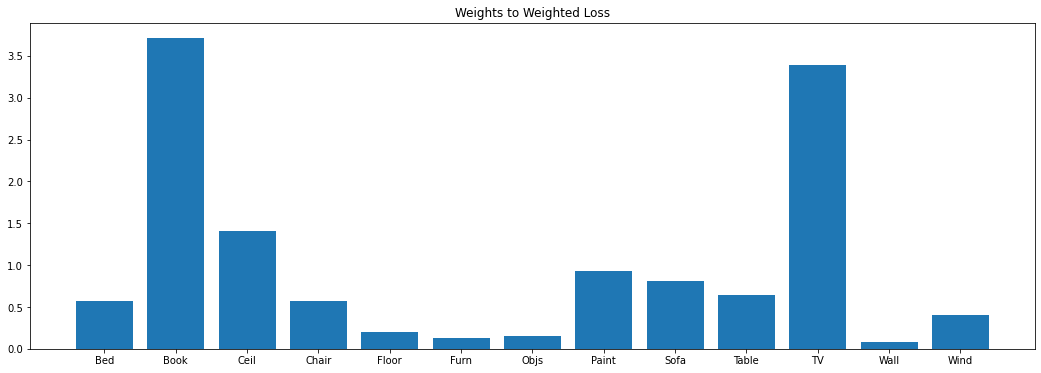

In [ ]:
weighted_loss_values = np.array([2596997, 401145, 1055085, 2621632, 7627296, 11079604, 9694473, 1605117, 1839193, 2317834, 438709, 17795223, 3738536])
weighted_inv_values = np.array([1/2596997, 1/401145, 1/1055085, 1/2621632, 1/7627296, 1/11079604, 1/9694473, 1/1605117, 1/1839193, 1/2317834, 1/438709, 1/17795223, 1/3738536])
weighted_inv_pseudonorm = weighted_inv_values*weighted_loss_values.sum()
weighted_inv_norm = weighted_inv_pseudonorm*13/weighted_inv_pseudonorm.sum()

print(weighted_inv_norm)

labels = ['Bed','Book','Ceil','Chair','Floor','Furn','Objs','Paint','Sofa','Table','TV','Wall','Wind']
positions = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5]

fig = plt.figure(figsize=(18,6))
ax = fig.gca()
ax.bar(labels,weighted_inv_norm, align='center')
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

plt.title('Weights to Weighted Loss')
plt.show()